# Step 1. 인물모드 직접 해 보기

In [51]:
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from functools import lru_cache

In [52]:
seg_model = semantic_segmentation()
seg_model.load_pascalvoc_model("./models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5")

person_seg_color_bgr = (128,128,192)

In [53]:
def read_image(image_path):
    """
    주어진 경로의 이미지를 RGB로 읽어옵니다
    :param image_path: 읽어올 이미지 경로
    :return: 3D np.ndarray
    """
    brg_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(brg_image, cv2.COLOR_BGR2RGB)
    return rgb_image

def segment(image_path):
    """
    object segmenation을 수행한다.
    """
    return seg_model.segmentAsPascalvoc(image_path)

@lru_cache(maxsize=100)
def segment_cached(image_path):
    """
    segment cache wrapper
    """
    return segment(image_path)

def extract_bg_mask(seg_output):
    """
    주어진 segmentation 결과를 사용하여 배경(인물이 아닌) mask를 추출합니다.
    :param seg_output: segmentation 결과
    :return: 3D np.ndarray
    """
    bg_seg_map = np.any(seg_output != person_seg_color_bgr, axis=-1) # 사람을 제외한 픽셀
    bg_seg_mask = bg_seg_map.astype(np.uint8) * 255 # 1(True) -> 255
    bg_seg_mask_rgb = cv2.cvtColor(bg_seg_mask, cv2.COLOR_GRAY2RGB)
    return bg_seg_mask_rgb

def portrait_filter(image_path, ksize=(10,10)):
    """
    주어진 이미지에 인물사진 필터를 적용합니다.
    :param image_path: 필터를 적용할 이미지 경로
    :param ksize: 배경을 흐리게 하는 정도, 값이 클수록 흐려진다
    :return: 3D np.ndarray
    """
    image = read_image(image_path)
    
    _segvalues, seg_output = segment_cached(image_path)
    
    blur_image = cv2.blur(image, ksize=ksize)
    bg_mask = extract_bg_mask(seg_output)
    
    # 배경 mask에서 0인 부분은 사람, 255인 부분은 배경
    filtered_image = np.where(bg_mask==0, image, blur_image)
    return filtered_image


def chromakey_filter(image_path, bg_color=(0,255,0)):
    """
    주어진 이미지에 크로마키 필터를 적용합니다.
    :param image_path: 필터를 적용할 이미지 경로
    :param bg_color: 크로마키 배경 색상 RGB, 기본은 초록색(0,255,0) 
    :return: 3D np.ndarray
    """
    image = read_image(image_path)
    
    _segvalues, seg_output = segment_cached(image_path)
    
    chromakey_bg = np.full(image.shape, bg_color, dtype=np.uint8)
    bg_mask = extract_bg_mask(seg_output)
    
    # 배경 mask에서 0인 부분은 사람, 255인 부분은 배경
    filtered_image = np.where(bg_mask==0, image, chromakey_bg)
    return filtered_image


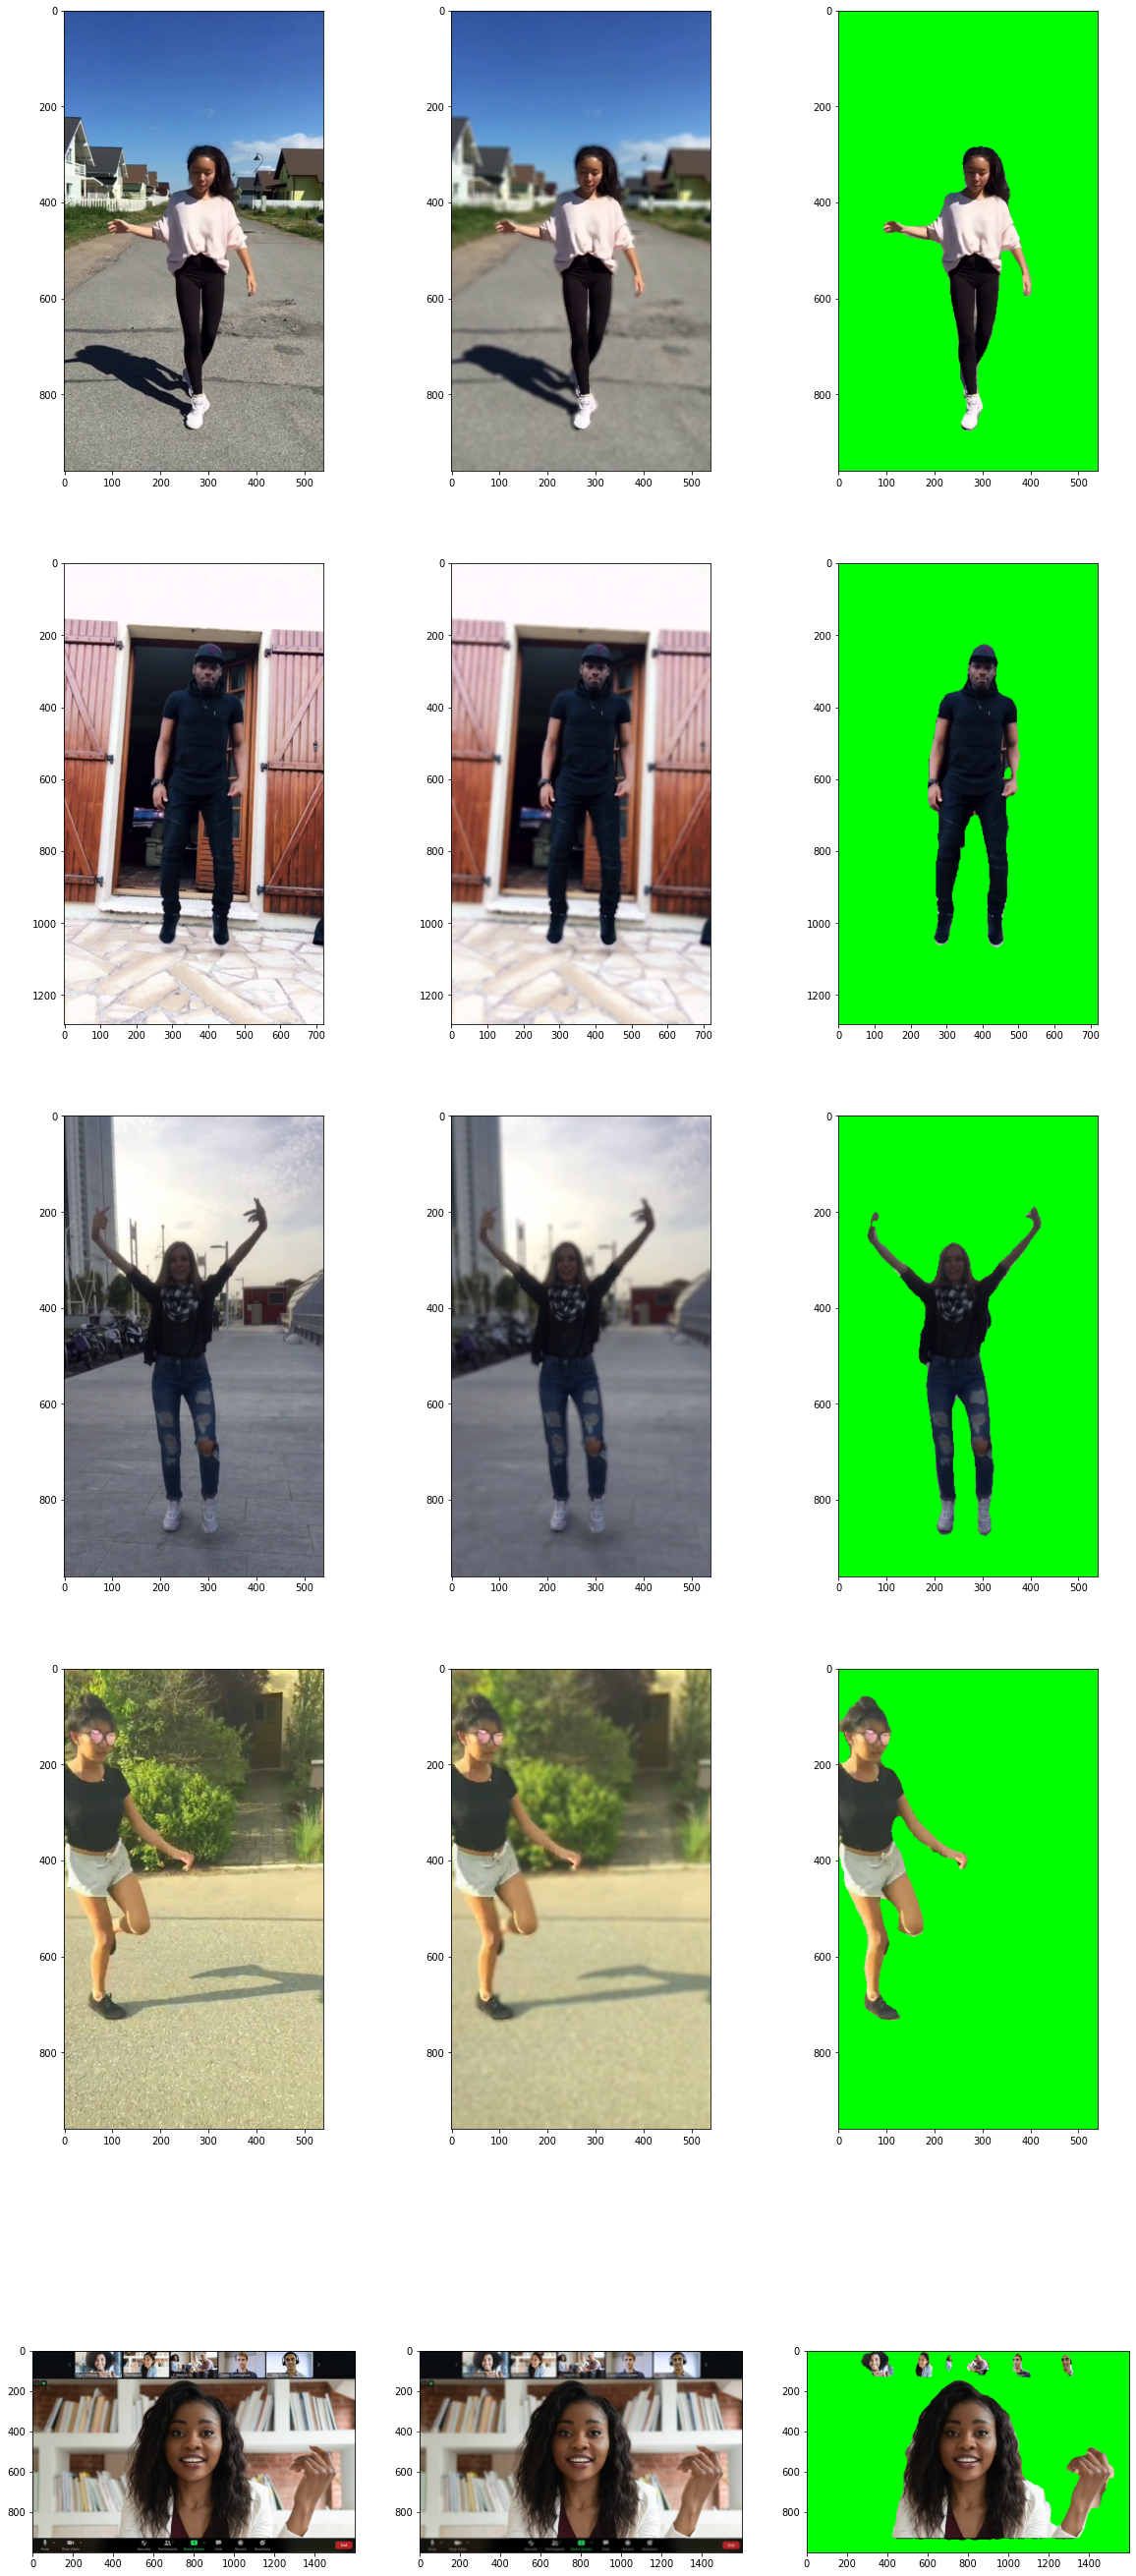

In [54]:
from matplotlib import pyplot as plt

total_sample_count = 5
plt.figure(figsize=(20, total_sample_count*10))

plot_count = 1
for i in range(1, total_sample_count+1):
    image_path = f"images/sample{i}.png"

    plt.subplot(total_sample_count, 3, plot_count)
    plt.imshow(read_image(image_path))
    plot_count += 1
    
    plt.subplot(total_sample_count, 3, plot_count)
    plt.imshow(portrait_filter(image_path))
    plot_count += 1
    
    plt.subplot(total_sample_count, 3, plot_count)
    plt.imshow(chromakey_filter(image_path))
    plot_count += 1


# Step 2. 사진에서 문제점 찾기

- 인체 사이의 좁은 공간을 사람으로 판별하는 케이스가 있다.

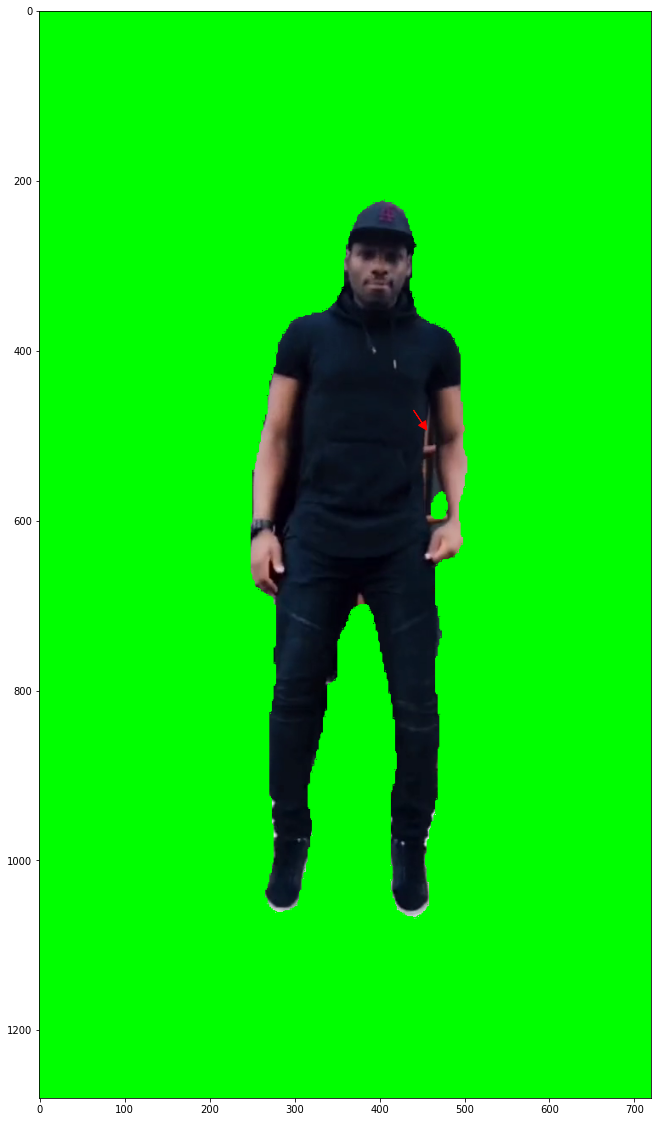

In [55]:
plt.figure(figsize=(20, 20))

plt.imshow(chromakey_filter("images/sample2.png"))
plt.arrow(440, 470, 10, 15, head_width=10, head_length=10, fc="r", ec="r")

- 인체의 작은 말단부를 명확하게 식별 못하는 케이스가 있다.

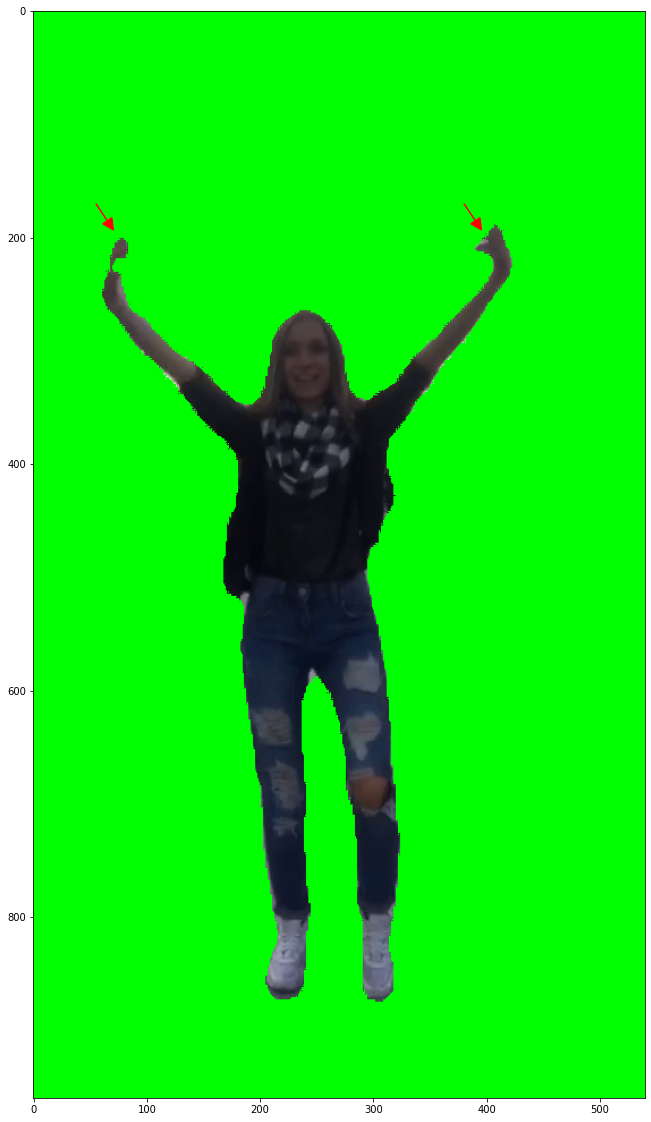

In [56]:
plt.figure(figsize=(20, 20))
plt.imshow(chromakey_filter("images/sample3.png"))
plt.arrow(55, 170, 10, 15, head_width=10, head_length=10, fc="r", ec="r")
plt.arrow(380, 170, 10, 15, head_width=10, head_length=10, fc="r", ec="r")

- 사람이 작게 찍혀있는 경우 제대로 식별하지 못한다.

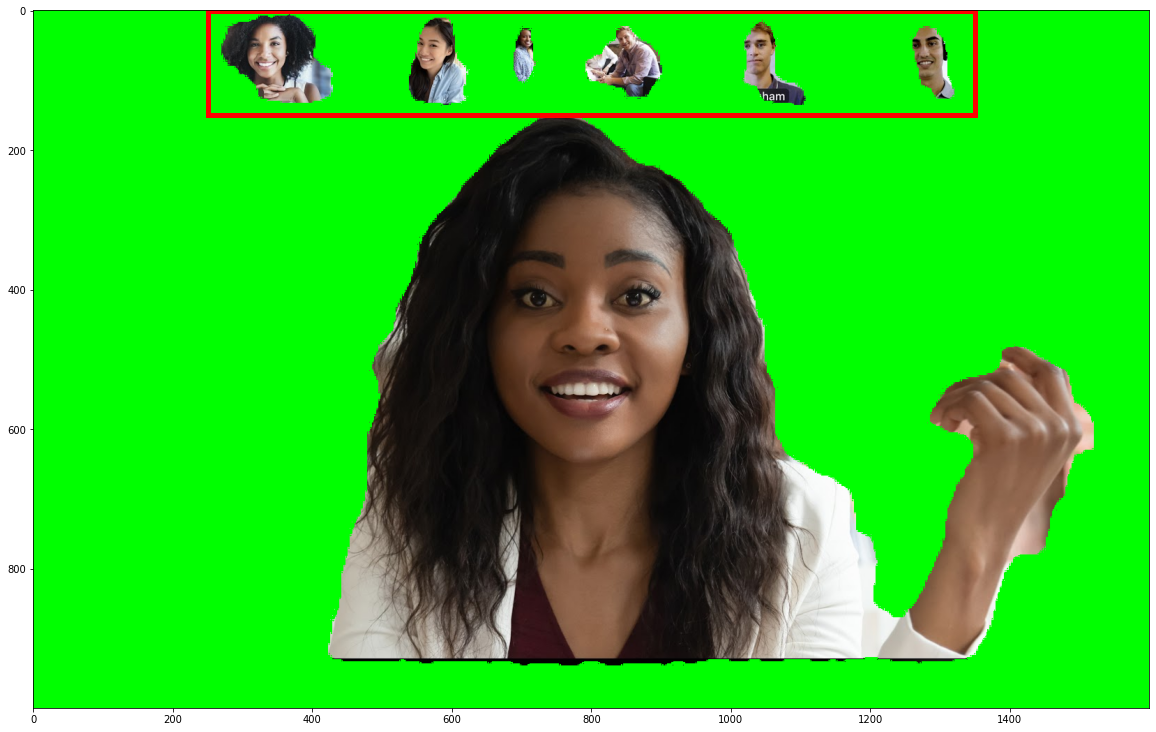

In [57]:
plt.figure(figsize=(20, 20))
plt.imshow(chromakey_filter("images/sample5.png"))

from matplotlib import patches

rect = patches.Rectangle((250, 0), 1100, 150, 
                         linewidth=5, edgecolor="r", facecolor="none")

plt.gca().add_patch(rect)


# Step 3. 해결 방법을 제안해 보기

- 모델의 오류를 기술적으로 보정하는 방법에 대해서는 컴퓨터 비전과 관련된 깊은 이해가 필요하기 때문에 앞서 언급했던 문제들을 기술적으로 어떻게 개선할 수 있을지는 떠오르진 않는다.

- 하지만 segmentation 모델이 아무리 발전하여도 모든 케이스의 이미지에 대해서 정확하게 segmentation을 할 수 없을 것이기 때문에 프로덕트 레벨에서 기획으로 풀어야할 문제로도 보인다.
  - ChatGPT를 통해 이미지를 생성할 때 생성된 이미지에서 부분만 수정할 수 있는 기능을 제공하는데  
    이와 비슷하게 blur 처리가 되면 안되는 영역을 사용자가 지정할 수 있게끔 하는 방식으로 이 문제를 풀 수도 있을 것 같다.

<img width="500px" src="opinion.png">

---

### 회고

- 행렬 연산이 꽤나 복잡해서 생각한 대로 이미지를 다루는게 쉽지 않았다.
- 실제 프로덕트를 만든다는 생각으로 고민할 수 있어서 좋았다.
- 기술적으로 잘 알지 못하고 가져다만 쓰다보니 기술적인 개선 방안이 떠오르지 않은 점은 아쉽다.